Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.distributions as dist
import torch.nn as nn

from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid

import itertools

%matplotlib inline

# Fitting a variational auto-encoder

In part two of this coursework, you will fit a variational autoencoder to the MNIST dataset.

We'll download the data and plot a few images.

In [2]:
# Download the dataset and apply necessary transformations

mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.round())])
mnist_dataset = MNIST(root='data/', download=True, train=True, transform=mnist_transforms)
train_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=100, shuffle=True)

## Data format

Each MNIST image $x_i$ is a **binary image** with shape `(1, 28, 28)`, i.e.

$$x_i \in \{0, 1\}^{1\times28\times28}$$

The first dimension is the number of "channels". It is `1` because these are black-and-white images. (For color images, there are three channels.)

The convention in pytorch is for images to be `[channels][rows][columns]`. This is different than numpy, which you might be familiar with, which instead has `[rows][columns][channels]`. We will have to call `torch.permute` to re-arrange the axes, sometimes.

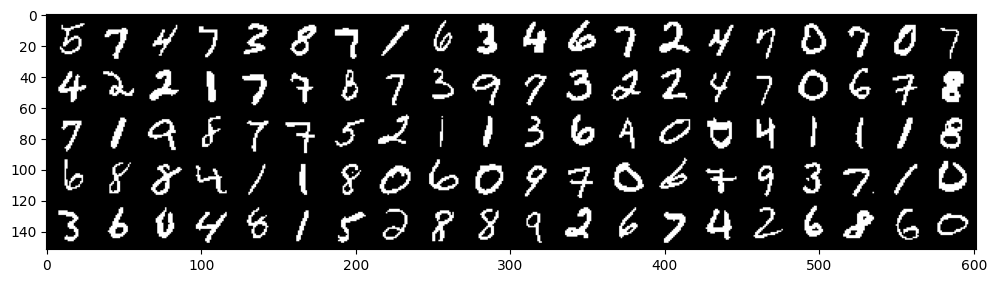

In [3]:
plt.figure(figsize=(12,5))
X_random_batch, y_random_batch = next(iter(train_loader))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0));

# TASK 1 (6 points + 2 bonus): Define encoder and decoder networks

We have data $x_i$ and will learn a latent representation $z_i \in \mathbb{R}^{D}$.

To do this we define two different networks, each as an `nn.Module` instance.


* The **Encoder** defines an inference network. It takes a batch of data instances as inputs, and returns a probability distribution $q(z_i | x_i)$ for each $x_i$ in the batch.
* The **Decoder** defines the likelihood in a generative model. It takes a latent value as input, and returns a probability distribution $p(x_i | z_i)$.

## You can use any network architecture you think is appropriate.

Part of your job here is to decide.

* You can get up to 6 points (3 points each) for having an implementation of any non-linear model that runs properly and can be used to fit some sort of VAE. If it doesn't quite work (or if you just implement a linear model, or a poor choice of architecture which leads to bad results) then you will get partial credit.

* You can get 2 additional points if you do something "interesting", by which I specifically mean "more performant". In particular we are looking for architectures which
    - (a) perform better than a feed-forward network, while 
    - (b) having fewer parameters.

In particular: for full *bonus* credit, for a model with `D_latent = 10` you should have fewer than 10,000 parameters each in the encoder and decoder, while still having realistic reconstructions. 


# We will use two convolutional layers plus two linear fully connected layers for our architecture, as this is standard for small b/w images (in particular MNIST data)


In [4]:
class Encoder(nn.Module):
    def __init__(self, D_latent):
        """ 
        Initialize the Encoder `nn.Module`.

        INPUTS:
        D_latent: size of latent space (integer)
        """
        super().__init__()
        self.D_latent = D_latent
        
        ## Convolutional layers ##
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        
        ## Fully connected layers for mean and std ##
        self.fc_mu = nn.Linear(392, D_latent) 
        self.fc_sigma = nn.Linear(392, D_latent)  

    def forward(self, X):
        """ Return a distribution q(z | x). """
        
        ## Apply convolutional layers ##
        h = self.conv1(X)
        h = self.relu1(h)
        h = self.conv2(h)
        h = self.relu2(h)
        h = h.view(h.size(0), -1)  ## Flatten the output for linear layers ##

        ## Retrieve mean and std ##
        mu = self.fc_mu(h)
        sigma = torch.exp(0.5 * self.fc_sigma(h))
        
        ## Return normal distribution ##
        return dist.Normal(mu, sigma)


In [5]:
class Decoder(nn.Module):
    def __init__(self, D_latent):
        """ 
        Initialize the Decoder `nn.Module`.
        
        This will operate on inputs of shape (batch_size, D_latent).
        
        INPUTS:
        D_latent: size of latent space (integer)
        """
        super().__init__()
        self.D_latent = D_latent
        
        ## Fully connected layer to expand into feature space ##
        self.fc = nn.Linear(D_latent, 784) 
        
        ## Deconvolutional layers ##
        self.deconv1 = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu1 = nn.ReLU()
        self.deconv2 = nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, Z):
        """ 
        Forward pass through the decoder.
        
        INPUT:
        Z : Latent vector of shape (batch_size, D_latent)
        
        OUTPUT:
        A Bernoulli distribution over reconstructed images, shape (batch_size, 1, 28, 28)
        """
        
        h = self.fc(Z)  
        h = h.view(h.size(0), 16, 7, 7) 
        h = self.deconv1(h)
        h = self.relu1(h)
        h = self.deconv2(h)
        X_hat = self.sigmoid(h)
        
        ## Return Bernoulli distribution ##
        return dist.Bernoulli(probs=X_hat)


# TASK 2 (5 points): Define the objective function

You now need to define the ELBO, which we will maximize when estimating parameters in the encoder and decoder.

## Please use a standard normal prior $N(0, I)$ for the latent space.

I.e., let $$z \sim \mathcal{N}(0, I_D)$$ where $D$ is the dimensionality of the latent space.

The `ELBO_VAE` function should return a **single-sample** Monte Carlo estimate of

$$ELBO(x_i) = \mathbb{E}_{q(z_i | x_i)}\left[ \log \left [ \frac{p(z_i)p(x_i | z_i)}{q(z_i | x_i)} \right ] \right ]$$

where $q(z_i | x_i)$ and $p(x_i | z_i)$ are returned by the `Encoder` and `Decoder` classes you defined above.

Note that I have written this as the **per-datapoint** ELBO. 

For ease of inspecting your code, please have your `ELBO_VAE` function below return a Torch vector, i.e. a tensor of shape `(batch_size,)`, containing the per-datapoint ELBO values.


In [6]:
def ELBO_VAE(enc, dec, X):
    """
    Compute the per-datapoint Evidence Lower Bound (ELBO) for a Variational Autoencoder (VAE).

    INPUT:
    enc : Instance of `Encoder` class, which returns a distribution 
          over Z when called on a batch of inputs X.
    dec : Instance of `Decoder` class, which returns a distribution 
          over X when called on a batch of inputs Z.
    X   : A batch of datapoints, torch.FloatTensor of shape = (batch_size, 1, 28, 28).
    
    OUTPUT:
    torch.FloatTensor of shape = (batch_size, ) containing the estimate 
    of the per-datapoint ELBO for every data point in the batch.
    """
    ## Reparameterisation trick ##
    q_zx = enc(X) 
    z_sample = q_zx.rsample() 
    
    ## Compute the prior ##
    p_z = dist.Normal(0, 1)
    log_pz = p_z.log_prob(z_sample).sum(1)
    
    ## Compute the log likelihood ##
    p_xz = dec(z_sample) 
    log_pxz = p_xz.log_prob(X).sum((1, 2, 3))
    
    ## Compute the posterior ##
    log_qzx = q_zx.log_prob(z_sample).sum(1)
    
    ## ELBO formula ##
    elbo = log_pz + log_pxz - log_qzx 

    return elbo


# Train the VAE and look at the results

The following code to train and run the VAE has already been written for you. 

You can use it to evaluate whether or not your model is working as you might expect, and for experimenting with its behavior as you change different parameters.

You should't have to change the two following cells. Feel free to modify them (e.g. for adding debugging information), but be aware that I will test your implementations with substantially similar code. So, your code should be runnable by calling these cells as-is.

In [7]:
# Try modifying this and seeing how it affects performance!
D_latent = 10

enc = Encoder(D_latent)
dec = Decoder(D_latent)

opt_vae = torch.optim.Adam(itertools.chain(enc.parameters(), dec.parameters()))
p_enc = (sum([parameter.numel() for parameter in enc.parameters()]))
p_dec = (sum([parameter.numel() for parameter in dec.parameters()]))

print(f"Encoder has {p_enc} parameters and decoder has {p_dec} parameters")

Encoder has 8196 parameters and decoder has 9857 parameters


In [8]:
def run_training(N_epochs, enc, dec):
    """ Outer loop for training the VAE 
    
        Calls your `ELBO_VAE` function!
    """
    for epoch in range(N_epochs):
        train_loss = 0.0
        for (X, _) in train_loader:
            opt_vae.zero_grad()
            
            # Call you ELBO implementation
            elbos = ELBO_VAE(enc, dec, X)
            
            # Please don't break the following assertion (check your return shape!)
            batch_size = X.shape[0]
            assert elbos.shape == (batch_size,)
            
            # The loss is the sum of the negative per-datapoint ELBO
            loss = -elbos.sum()
            loss.backward()
            opt_vae.step()
            train_loss += loss.item() * X.shape[0] / len(mnist_dataset)
        print("Epoch %d, train loss = %0.4f" % (epoch, train_loss));

In [9]:
# ignore this cell (placeholder)


In [10]:
N_epochs = 50 # Note that you may want to run more epochs!
run_training(N_epochs, enc, dec)

Epoch 0, train loss = 21012.9484
Epoch 1, train loss = 13335.1415
Epoch 2, train loss = 12503.4401
Epoch 3, train loss = 12012.7809
Epoch 4, train loss = 11755.6798
Epoch 5, train loss = 11586.3256
Epoch 6, train loss = 11458.3368
Epoch 7, train loss = 11356.1184
Epoch 8, train loss = 11268.4913
Epoch 9, train loss = 11201.8664
Epoch 10, train loss = 11143.4380
Epoch 11, train loss = 11089.1217
Epoch 12, train loss = 11049.4479
Epoch 13, train loss = 11002.7238
Epoch 14, train loss = 10965.3658
Epoch 15, train loss = 10932.1182
Epoch 16, train loss = 10901.5255
Epoch 17, train loss = 10876.3701
Epoch 18, train loss = 10854.2762
Epoch 19, train loss = 10822.8794
Epoch 20, train loss = 10803.6849
Epoch 21, train loss = 10785.9488
Epoch 22, train loss = 10766.0799
Epoch 23, train loss = 10748.5739
Epoch 24, train loss = 10731.8108
Epoch 25, train loss = 10717.4280
Epoch 26, train loss = 10704.8320
Epoch 27, train loss = 10688.0244
Epoch 28, train loss = 10678.6221
Epoch 29, train loss = 1

## Do reconstructions look like the input?

Reconstruction accuracy: 0.94


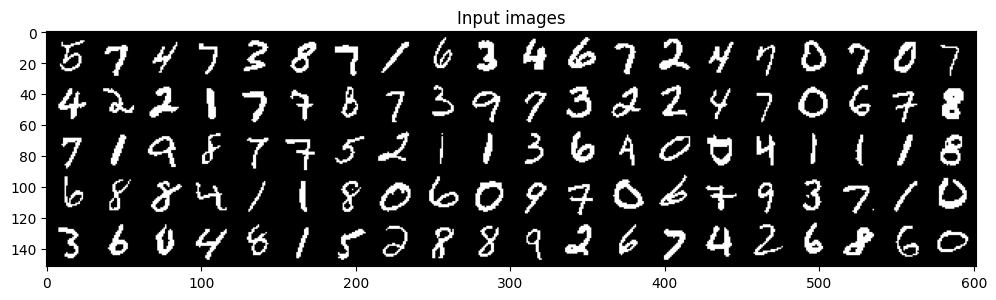

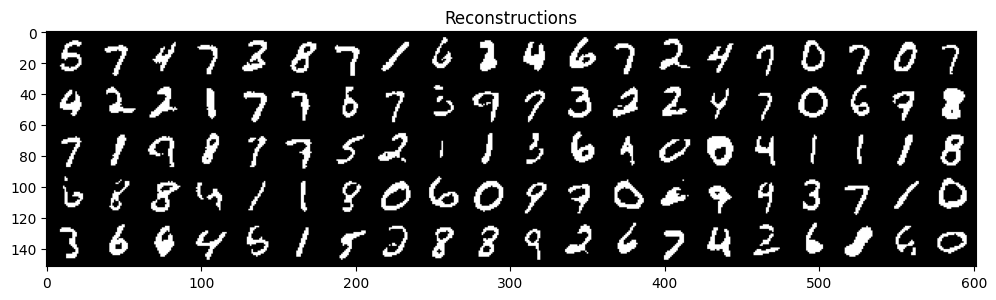

In [11]:
plt.figure(figsize=(12, 4))
plt.imshow(make_grid(X_random_batch, nrow=20).permute(1,2,0))
plt.title("Input images")
plt.figure(figsize=(12, 4))
plt.title("Reconstructions")
with torch.no_grad():
    plt.imshow(make_grid(dec(enc(X_random_batch).sample()).mean.round(), nrow=20).permute(1,2,0))
    
print("Reconstruction accuracy: %0.2f" % (X_random_batch == dec(enc(X_random_batch).sample()).sample()).float().mean().item())

## Do randomly generated samples look coherent?

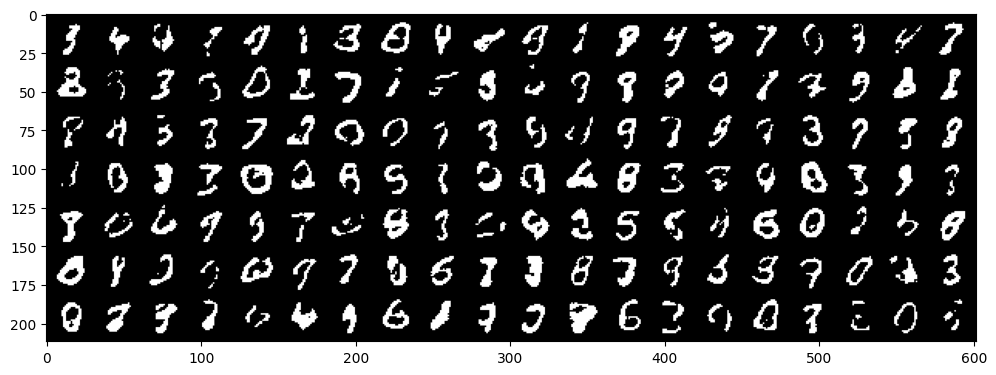

In [12]:
plt.figure(figsize=(12,5))
with torch.no_grad():
    plt.imshow(make_grid(dec(dist.Normal(0, 1).sample((140, D_latent))).mean.round(), nrow=20).permute(1,2,0), vmin=0, vmax=1)

## What does the latent space look like?

Note that this will only give sensible plots for very low-dimensional latent spaces. It works best if the latent space is actually 2d. Otherwise, it will plot a 2d cross-section that may or may not be informative.

/home/asagauntlett/PycharmProjects/pythonProject/.venv/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


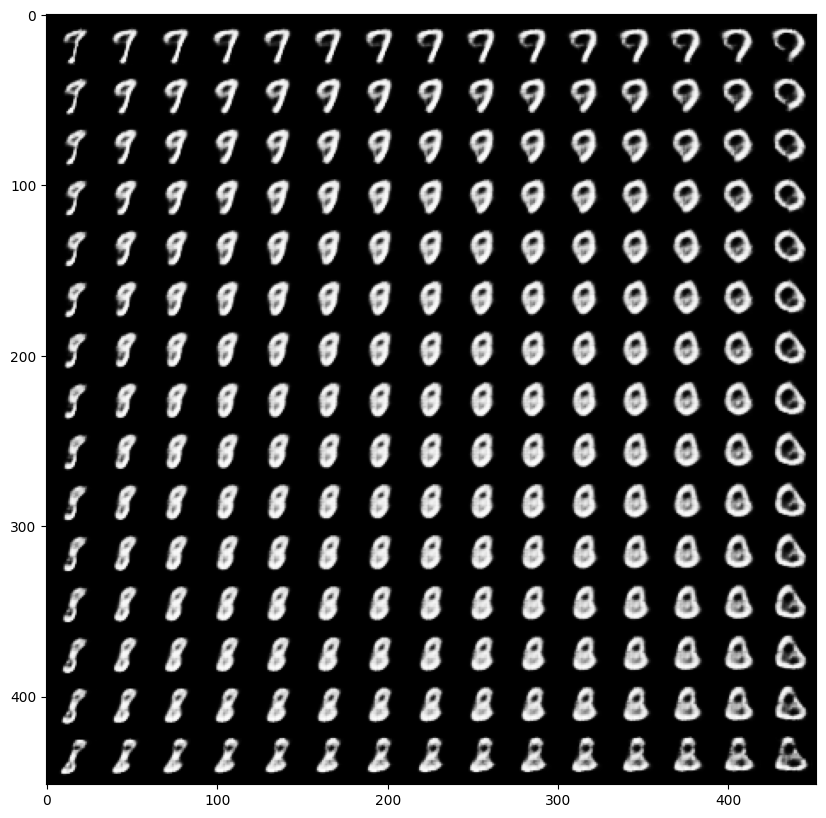

In [13]:
def plot_2d_latent(encoder, decoder):
    """ If this is a 2d latent space, it plots the latent space
        If the latent space is larger than 2d, then it plots a 2d cross-section """
    W = torch.linalg.svd(encoder(X_random_batch).mean).Vh[:2]
    points = dist.Normal(0, 1).icdf(torch.linspace(0.01, 0.99, 15))
    XX, YY = torch.meshgrid(points, points)
    XXYY = torch.stack((XX, YY)).reshape(2, -1).T
    with torch.no_grad():
        out = dec(XXYY @ W).mean
    plt.imshow(make_grid(out, nrow=len(points)).permute(1,2,0))

plt.figure(figsize=(10, 10))
out = plot_2d_latent(enc, dec)

In [14]:
# feel free to try out other things here -- for example, interpolation in the latent space between two digits

In [15]:
# grading


In [16]:
# grading


In [17]:
# grading


In [18]:
# grading


In [19]:
# grading


In [20]:
# grading


In [21]:
# grading
